In [364]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from IPython.display import clear_output
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
import pandas as pd


dwellings_share = 0.15


class WealthAgent(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, technology, bad_dwelling=False, inability=False, arrears=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.technology = technology
        self.bad_dwelling = bad_dwelling
        self.inability = inability
        self.arrears = arrears
    
    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        # As per your description: energy_price * (dwelling + technology)
        # We will need to access energy_price from the model.
        return self.model.energy_price * (self.dwelling + self.technology)

    def check_arrears(self):
        """Check if the agent has arrears and update the agent's status."""
        # As per your description: disposable_income < energy_price * (dwelling + technology)
        if self.disposable_income < self.energy_cost:
            self.arrears = True
        else:
            self.arrears = False

    def check_inability(self):
        """Check if the agent has inability to keep home adequately warm and update the agent's status."""
        # As per your description: energy_cost > 0.1 * disposable_income
        if self.energy_cost > 0.1 * self.disposable_income:
            self.inability = True
        else:
            self.inability = False

    def improve_dwelling_or_technology(self, improvement_budget):
        """Agent can improve their dwelling or technology if they have enough disposable income."""
        # We'll need to determine the specifics of how improvements affect dwelling and technology,
        # and how much they cost.
        pass

    def step(self):
        """Define the agent's behavior in a single step of the model."""
        self.check_arrears()
        self.check_inability()

class GiniCalculationError(Exception):
    pass

class WealthModel(Model):

    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        error_message = f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}"
        raise GiniCalculationError(error_message)
    

    def assign_dwelling_and_technology(self):
        # Generate enough dwelling and technology values for all agents
        dwelling_values = np.sort(np.random.randint(500, 1800, self.num_agents))
        technology_values = np.sort(np.random.randint(200, 600, self.num_agents))

        incomes_check = [agent.disposable_income for agent in self.schedule.agents]
        lower_threshold = np.percentile(incomes_check, 25)
        upper_threshold = np.percentile(incomes_check, 75)

        # Separate agents by income levels
        low_income_agents = [a for a in self.schedule.agents if a.disposable_income < lower_threshold]
        medium_income_agents = [a for a in self.schedule.agents if lower_threshold <= a.disposable_income < upper_threshold]
        high_income_agents = [a for a in self.schedule.agents if a.disposable_income >= upper_threshold]


        # Assign high dwelling and technology values to a proportion of each income group
        for agents, proportion in zip([low_income_agents, medium_income_agents, high_income_agents], [0.6, 0.25, 0.15]):
            num_high_values = int(proportion * len(agents))
            for agent in np.random.choice(agents, num_high_values, replace=False):
                if len(dwelling_values) > 0 and len(technology_values) > 0:
                    agent.dwelling = dwelling_values[-1]
                    agent.technology = technology_values[-1]
                    dwelling_values = np.delete(dwelling_values, np.where(dwelling_values == agent.dwelling)[0][0])
                    technology_values = np.delete(technology_values, np.where(technology_values == agent.technology)[0][0])

        # Assign remaining dwelling and technology values randomly to the rest of the agents
        remaining_agents = [agent for agent in self.schedule.agents if agent.dwelling == None]
        for agent in remaining_agents:
            if len(dwelling_values) > 0 and len(technology_values) > 0:
                agent.dwelling = np.random.choice(dwelling_values)
                dwelling_values = np.delete(dwelling_values, np.where(dwelling_values == agent.dwelling)[0][0])
                agent.technology = np.random.choice(technology_values)
                technology_values = np.delete(technology_values, np.where(technology_values == agent.technology)[0][0])



    def __init__(self, N, median_income, gini_target, rate, energy_price_x, share_fuel_x, energy_price_y, share_fuel_y):
        self.num_agents = N
        self.median_income = median_income
        self.gini_target = gini_target
        self.rate = rate
        self.energy_price_x = energy_price_x
        self.share_fuel_x = share_fuel_x
        self.energy_price_y = energy_price_y
        self.share_fuel_y = share_fuel_y
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            # We can update what data to collect here later.
        )

        # Generate disposable incomes according to a gamma distribution shaped by the Gini coefficient
        incomes = WealthModel.generate_income_distribution(self.num_agents, self.median_income, self.gini_target)


        
        # Create agents
        for i in range(self.num_agents):
            # We will update this section with the detailed logic for initializing
            # agents' dwellings, and technologies.
            a = WealthAgent(i, self, disposable_income=incomes[i], dwelling=None, technology=None)
            self.schedule.add(a)

        self.assign_dwelling_and_technology()

        self.datacollector = DataCollector(
            agent_reporters={"Dwelling": "dwelling", 
                             "Technology": "technology", 
                             "Income": "disposable_income",
                             "arrears":"arrears",
                             "Inability":"inability",
                             "EnergyCost": "energy_cost",
                            "disp_utility": lambda agent: agent.disposable_income - agent.energy_cost}
        )

    @property
    def energy_price(self):
        """Calculate and return the current energy price in the model."""
        # As per your description: energy_price_x * share_fuel_x + energy_price_y * share_fuel_y
        return self.energy_price_x * self.share_fuel_x + self.energy_price_y * self.share_fuel_y

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

model = WealthModel(100, 50000, 0.5, [0.01, 0.05], 1, 0.5, 1, 0.5)

for i in range(100):   # this is the simulation loop
    model.step()



agent_data = model.datacollector.get_agent_vars_dataframe()

In [365]:
agent_data.Inability.unique()

array([False,  True])

In [366]:
agent_data.tail(99).sort_values(['disp_utility'])

Dwelling  Technology         Income  arrears  Inability  \
Step AgentID                                                            
99   38           1685         573    1713.487368     True       True   
     65           1596         534    1604.671051     True       True   
     87           1762         595    2177.067628     True       True   
     36           1392         251    2083.497271    False       True   
     86           1206         216    2373.773800    False       True   
...                ...         ...            ...      ...        ...   
     20            613         324  127487.130192    False      False   
     32           1298         336  130220.213227    False      False   
     60           1004         339  167739.178890    False      False   
     18            961         295  208899.210280    False      False   
     50            716         300  232648.258183    False      False   

              EnergyCost   disp_utility  
Step AgentID                             
99   38           2258.0    -544.512632  
     65           2130.0    -525.328949  
     87           2357.0    -179.932372  
     36           1643.0     440.497271  
     86           1422.0     951.773800  
...                  ...            ...  
     20            937.0  126550.130192  
     32           1634.0  128586.213227  
     60           1343.0  166396.178890  
     18           1256.0  207643.210280  
     50           1016.0  231632.258183  

[99 rows x 7 columns]

In [367]:
sorted_agent_data = agent_data.tail(99).sort_values(by='disp_utility', key=lambda x: abs(x))

In [368]:
sorted_agent_data

Dwelling  Technology         Income  arrears  Inability  \
Step AgentID                                                            
99   87           1762         595    2177.067628     True       True   
     36           1392         251    2083.497271    False       True   
     65           1596         534    1604.671051     True       True   
     38           1685         573    1713.487368     True       True   
     86           1206         216    2373.773800    False       True   
...                ...         ...            ...      ...        ...   
     20            613         324  127487.130192    False      False   
     32           1298         336  130220.213227    False      False   
     60           1004         339  167739.178890    False      False   
     18            961         295  208899.210280    False      False   
     50            716         300  232648.258183    False      False   

              EnergyCost   disp_utility  
Step AgentID                             
99   87           2357.0    -179.932372  
     36           1643.0     440.497271  
     65           2130.0    -525.328949  
     38           2258.0    -544.512632  
     86           1422.0     951.773800  
...                  ...            ...  
     20            937.0  126550.130192  
     32           1634.0  128586.213227  
     60           1343.0  166396.178890  
     18           1256.0  207643.210280  
     50           1016.0  231632.258183  

[99 rows x 7 columns]

In [369]:
agent_data.loc[agent_data.tail(99).sort_values(['Inability','Income','EnergyCost'])['Inability'].idxmax()]

Dwelling               1596
Technology              534
Income          1604.671051
arrears                True
Inability              True
EnergyCost           2130.0
disp_utility    -525.328949
Name: (99, 65), dtype: object

In [370]:
agent_data[agent_data['Inability'] == True]['Income'].max()

18844.7591126785

In [371]:
agent_data[agent_data['Inability'] == False]['Income'].min()

1604.671051191763

In [372]:
agent_data.Inability.tail(99).sum() / 99

0.3434343434343434

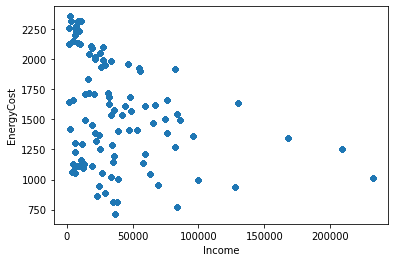

In [373]:
agent_data.reset_index().plot(kind='scatter', x='Income', y='EnergyCost')
plt.show()

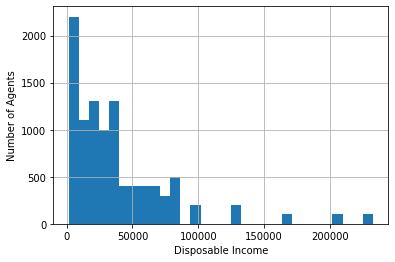

In [374]:
agent_data["Income"].hist(bins=30)
plt.xlabel('Disposable Income')
plt.ylabel('Number of Agents')
plt.show()


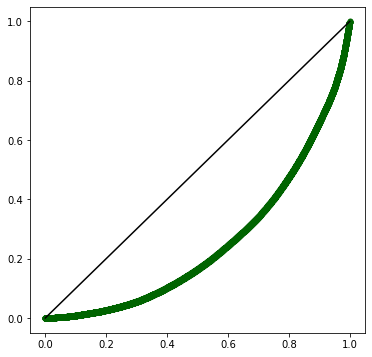

In [375]:
def plot_lorenz_curve(X, yummy_figs = (6, 6)):

    X_sorted = np.sort(X)  # Sort the incomes
    lorenz = np.cumsum(X_sorted) / np.sum(X_sorted)
    lorenz = np.insert(lorenz, 0, 0)
    lorenz[0], lorenz[-1]

    fig, ax = plt.subplots(figsize=[yummy_figs[0],yummy_figs[1]])
    ax.scatter(np.arange(lorenz.size)/(lorenz.size-1), lorenz, 
            marker='.', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

plot_lorenz_curve(agent_data["Income"])

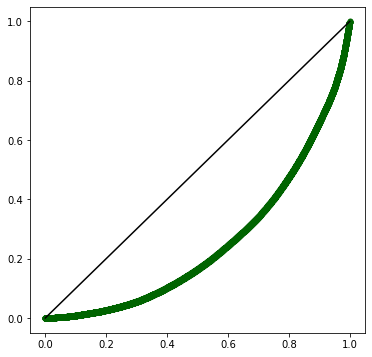

In [376]:
plot_lorenz_curve(agent_data["Income"])

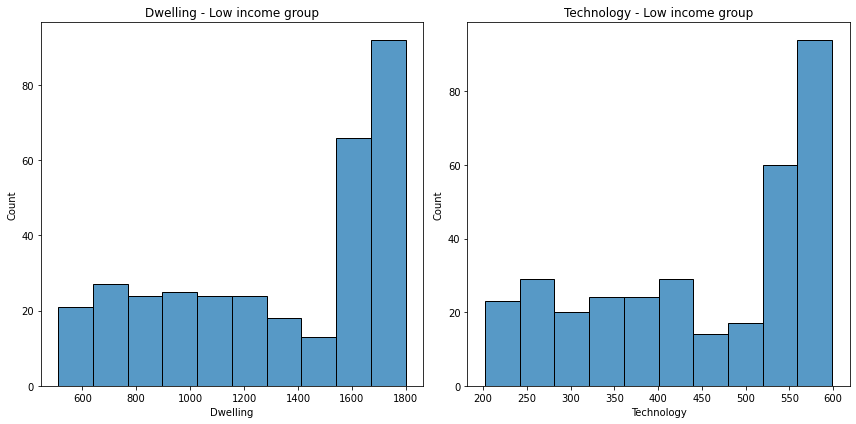

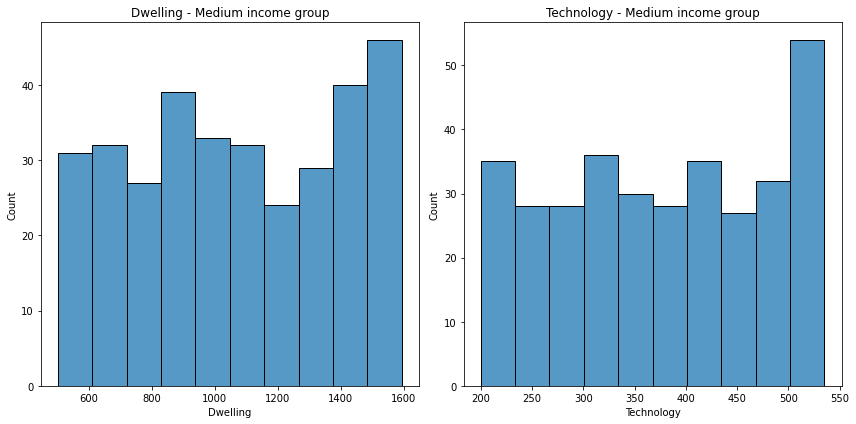

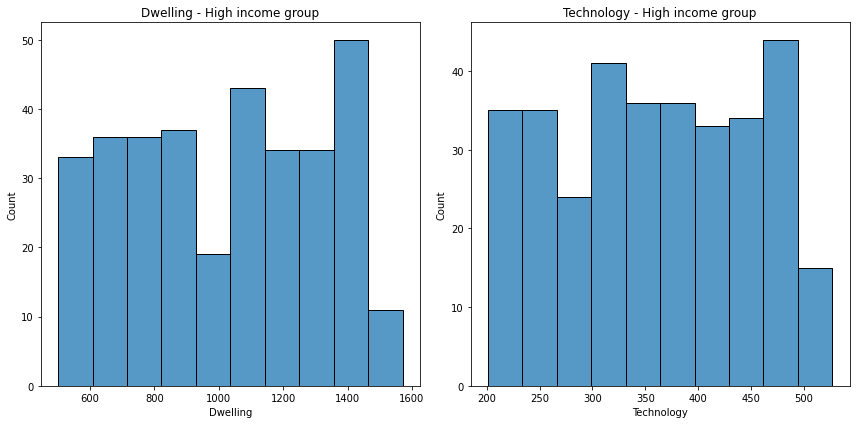

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by income
data['IncomeGroup'] = pd.qcut(data['Income'], q=3, labels=["Low", "Medium", "High"])

# Plot histograms for 'Dwelling' and 'Technology' for each income group
for group in ["Low", "Medium", "High"]:
    group_data = data[data['IncomeGroup'] == group]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(data=group_data, x="Dwelling", ax=axs[0])
    axs[0].set_title(f'Dwelling - {group} income group')

    sns.histplot(data=group_data, x="Technology", ax=axs[1])
    axs[1].set_title(f'Technology - {group} income group')

    plt.tight_layout()
    plt.show()


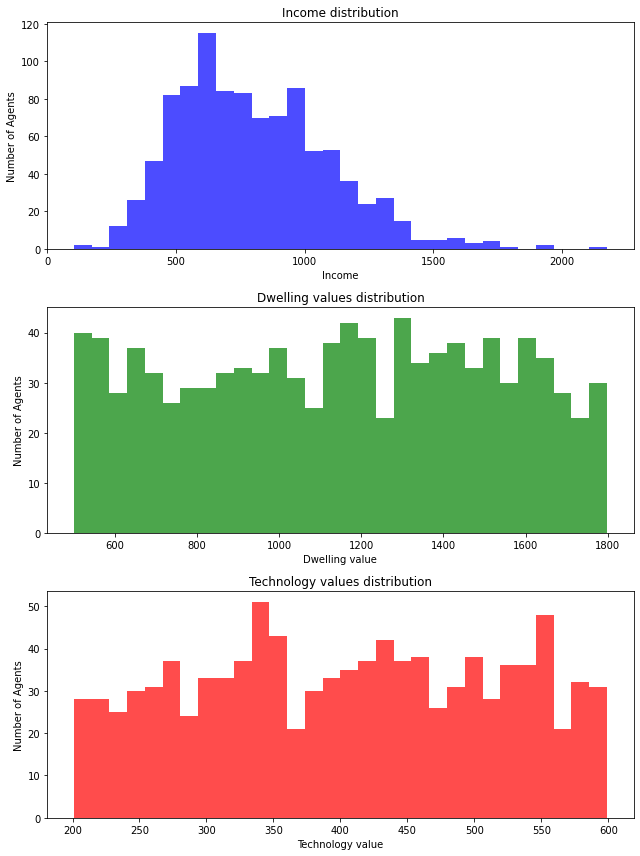

In [378]:
import matplotlib.pyplot as plt

# Instantiate the model
model = WealthModel(N=1000, median_income=800, gini_target=0.2, 
                    rate=[0.01, 0.05], energy_price_x=1, share_fuel_x=0.5, 
                    energy_price_y=1, share_fuel_y=0.5)

# Collect data
incomes = [agent.disposable_income for agent in model.schedule.agents]
dwellings = [agent.dwelling for agent in model.schedule.agents]
technologies = [agent.technology for agent in model.schedule.agents]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(9, 12))

# Plot income distribution
axs[0].hist(incomes, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Income distribution')
axs[0].set_xlabel('Income')
axs[0].set_ylabel('Number of Agents')

# Plot dwelling values distribution
axs[1].hist(dwellings, bins=30, color='green', alpha=0.7)
axs[1].set_title('Dwelling values distribution')
axs[1].set_xlabel('Dwelling value')
axs[1].set_ylabel('Number of Agents')

# Plot technology values distribution
axs[2].hist(technologies, bins=30, color='red', alpha=0.7)
axs[2].set_title('Technology values distribution')
axs[2].set_xlabel('Technology value')
axs[2].set_ylabel('Number of Agents')

# Show plots
plt.tight_layout()
plt.show()


In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from IPython.display import clear_output
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
import pandas as pd


class Household(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, bad_dwelling=False, inability=False, arrears=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.bad_dwelling = bad_dwelling
        self.inability = inability
        self.arrears = arrears

    def improve_dwelling(self, improvement_budget):
        """Agent can improve their dwelling or technology if they have enough disposable income."""
        # We'll need to determine the specifics of how improvements affect dwelling and technology,
        # and how much they cost.
        pass

    def step(self):
        """Define the agent's behavior in a single step of the model."""
        self.check_arrears()
        self.check_inability()

class GiniCalculationError(Exception):
    pass

class Country(Model):

    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, population, median_income, gini_target):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=population)
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        error_message = f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}"
        raise GiniCalculationError(error_message)
    
    def __init__(self, N, median_income, gini_target, rate, energy_price_x, share_fuel_x, energy_price_y, share_fuel_y):
        self.population = N
        self.median_income = median_income
        self.gini_target = gini_target
        self.rate = rate
        self.energy_price_x = energy_price_x
        self.share_fuel_x = share_fuel_x
        self.energy_price_y = energy_price_y
        self.share_fuel_y = share_fuel_y
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            # We can update what data to collect here later.
        )

        # Generate disposable incomes according to a gamma distribution shaped by the Gini coefficient
        incomes = Country.generate_income_distribution(self.population, self.median_income, self.gini_target)
        
        # Create agents
        for i in range(self.population):
            # We will update this section with the detailed logic for initializing
            # agents' dwellings, and technologies.
            a = Household(i, self, disposable_income=incomes[i])
            self.schedule.add(a)

        self.datacollector = DataCollector(
            agent_reporters={"Dwelling": "dwelling", 
                             "Income": "disposable_income",
                             "arrears":"arrears",
                             "Inability":"inability",
                             "EnergyCost": "energy_cost",
                            "disp_utility": lambda agent: agent.disposable_income - agent.energy_cost}
        )

    @property
    def energy_price(self):
        """Calculate and return the current energy price in the model."""
        # As per your description: energy_price_x * share_fuel_x + energy_price_y * share_fuel_y
        return self.energy_price_x * self.share_fuel_x + self.energy_price_y * self.share_fuel_y

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

model = Country(100, 50000, 0.5, [0.01, 0.05], 1, 0.5, 1, 0.5)

for i in range(100):   # this is the simulation loop
    model.step()



agent_data = model.datacollector.get_agent_vars_dataframe()

TypeError: __init__() missing 1 required positional argument: 'dwelling'